# RL с блэкджэком и Дастином Хоффманом

Этот ноутбук посвящен решению первого домашнего задания курса С. Николенко по обучению с подкреплением в рамках 3 семестра MADE.
Предлагается обучаться играть в очень простую, но знаменитую и популярную игру: [**блекджек**](https://en.wikipedia.org/wiki/Blackjack). 

## Часть первая, с блекджеком и стратегиями

### Введение

> давайте начнём с самой базовой версии, которая реализована в OpenAI Gym

In [4]:
from gym.envs.toy_text.blackjack import BlackjackEnv

Базовые правила, реализованные в `gym` (из docstring-а):

- цель игры - получить на руки карты, сумма которых как можно ближе к 21, но при этом не больше 21.
- стоимости карт: 
    - от 2 до 10 для карт с цифрами
    - 10 для валетов (Jack), дам (Queen) и королей (King)
    - 11 для туза (ace), если при этом сумма очков не выходит за 21 (такой случай называется usable ace), 1 - если выходит
- игра начинаеися с того, что раздается по 2 карты дилеру и игроку - игроку обе карты в открытую, дилеру - только одну карту в открытую
- каждый ход игрок может либо попросить еще карту (hit (`action == 1`)), либо остановиться (stick (`action == 0`))
- если игрок в очередной раз попросил карту и сумма его очков превысила 21 - он проиграл (bust), и его награда равна -1
- если игрок решил остановиться, дилер открывает свою закрытую карту и тянет карты в открытую до тех пор, пока его сумма очков не становится >= 17
- если дилер превысил 21 (goes bust) - он проиграл, награда игрока = 1
- если нет, то победитель определяется тем, у кого сумма очков ближе к 21. Если сумма очков дилера равна сумме очков игрока, засчитывается ничья, награда = 0

Кроме того, в реализации `gym` для `BlackjackEnv` есть еще две настройки - `natural=False` и `sab=False`.

- `natural=False` включает/выключает в правила награду в 1.5 за natural руку у игрока (natural - рука, сумма очков в которой равна 21 с первых двух карт)
- `sab=False` включает/выключает полную поддердку правил из примера 5.1 книги Reinforcement Learning: An Introduction (Sutton, Barto). Единственное различие, которое я увидел, заключается в том, как я понял, что если и у дилера и у игрока natural-рука, то это ничья

Попробуем позапускать:

In [5]:
env = BlackjackEnv(natural=True)
env.reset()

(20, 10, False)

Первое число - сумма на руке игрока, второе - стоимость открытой карты дилера, 3 - есть ли usable_ace.
Попросим еще карту

In [6]:
hit = 1
stick = 0
env.step(action=hit)

((26, 10, False), -1.0, True, {})

Ace, но не usable. Новые 2 числа - это текущая награда и закончился ли эпизод

In [7]:
env.step(action=hit)

((36, 10, False), -1.0, True, {})

:(

### 1.1 Наивная стратегия

 > Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [8]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod
from pprint import pprint

In [9]:
class BasePlayer(ABC):
    @abstractmethod
    def strategy(self, previous_state):
        raise NotImplementedError("Implement me in subclass")
    
    def action(self, previous_state):
        return self.strategy(previous_state)
    
    def set_training(self):
        self.training = True
    
    def set_playing(self):
        self.training = False

class NaivePlayer(BasePlayer):
    def strategy(self, previous_state):
        if len(previous_state) == 3:
            my_sum = previous_state[0]
        else:
            my_sum = previous_state[0][0]
        return int(my_sum < 19)

In [61]:
class BlackJackGame:
    def __init__(self, env):
        self.env = env
    
    def run_episode(self, player, return_history=False):
        episode_history = []
        previous_state = self.env.reset()
        previous_state = (previous_state, 0.0, False, {})
        (phand, dhand, is_usableace), reward, episode_ended, _ = previous_state
        episode_history.append((previous_state, None))
        while not episode_ended:
            action = player.action(previous_state)
            previous_state = self.env.step(action)
            (phand, dhand, is_usableace), reward, episode_ended, _ = previous_state
            episode_history.append((previous_state, action))
        if return_history:
            return reward, episode_history
        else:
            return reward
    
    def mc_check(self, player, n_iter=100_000, use_tqdm=True):
        mean_reward = self.run_episode(player, return_history=False)
        if use_tqdm:
            for i in tqdm(range(n_iter), total=n_iter):
                reward = self.run_episode(player, return_history=False)
                mean_reward += (reward - mean_reward) / (i + 1)
        else:
            for i in tqdm(range(n_iter - 1), total=n_iter):
                reward = self.run_episode(return_history=False)
                mean_reward += (reward - mean_reward) / (i + 1)
        return mean_reward

In [62]:
nplayer = NaivePlayer()
game = BlackJackGame(env)

In [37]:
mean_reward = game.mc_check(nplayer, n_iter=500000)
print(f'Средний выигрыш = {mean_reward: .4f}')

  0%|          | 0/500000 [00:00<?, ?it/s]

Средний выигрыш = -0.1790


In [13]:
reward, episode_history = game.run_episode(nplayer, return_history=True)
pprint(episode_history)

[(((12, 5, False), 0.0, False, {}), None),
 (((22, 5, False), -1.0, True, {}), 1)]


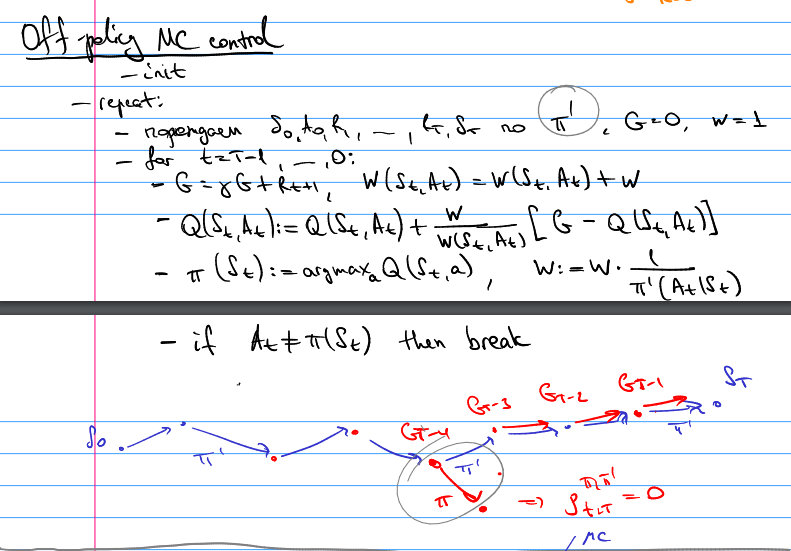

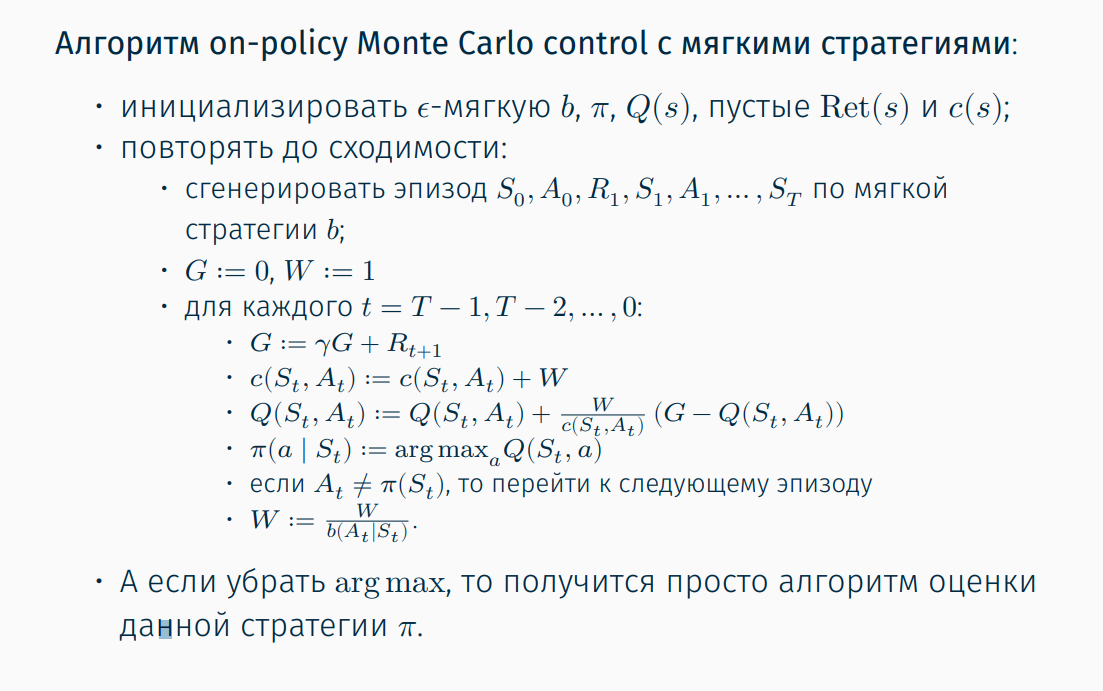

In [24]:
from collections import defaultdict

class OffPolicySoftGreedyMCControlPlayer(BasePlayer):
    
    def __init__(self, action_dim, eps=1e-3, gamma=1):
        self.set_training()
        self.eps = eps
        self.gamma = gamma
        self.q = defaultdict(lambda: np.zeros(action_dim))
        self.c = defaultdict(lambda: np.zeros(action_dim))
        self.action_dim = action_dim
    
    def update_q(self, episode_history):
        prob_greedy_action = 1 - (self.action_dim - 1) * self.eps / self.action_dim # Damn?
        if not self.training:
            raise ValueError('Player must be in training mode for updating Q. Use player.set_training()')
        else:
            g = 0
            w = 1
            for t in np.arange(len(episode_history) - 1, -1, -1):
                (state, reward, is_done, _), prev_action = episode_history[t]
                g = self.gamma * g + reward
                self.c[state][prev_action] += w
                self.q[state][prev_action] += (w / self.c[(state, prev_action)]) * (g - self.q(state, prev_action))
                greedy_action = self.greedy_step(state)
                if greedy_action != prev_action:
                    return
                w /= prob_greedy_action
    
    def greedy_step(self, previous_state):
        return np.argmax(self.q[previous_state])
    
    def soft_greedy_step(self, previous_state):
        coin = np.random.rand()
        if coin > self.eps:
            return self.greedy_step(previous_state)
        else:
            return np.random.randint(self.action_dim)
    
    def strategy(self, previous_state):
        if self.training:
            return self.soft_greedy_step(previous_state)
        else:
            return self.greedy_step(previous_state)

In [25]:
cool_player = OffPolicySoftGreedyMCControlPlayer(2)
state = env.reset()

In [54]:
class Trainer:
    def __init__(self):
        pass
    
    def train(self, player, game, n_iter, callback=None):
        for i in range(n_iter):
            episode_history = game.run_episode(player, return_history = True)
            player.update_q(episode_history)

In [60]:
trainer = Trainer()
trainer.train(cool_player, game, 25)

(-1.0, [(((13, 2, False), 0.0, False, {}), None), (((13, 2, False), -1.0, True, {}), 0)])


ValueError: not enough values to unpack (expected 4, got 2)

In [51]:
cool_player.greedy_step(state)

0

In [43]:
np.argmax(cool_player.q[state])

0

In [23]:
np.arange(5, -1, -1)

array([5, 4, 3, 2, 1, 0])

In [8]:
1 ?1

SyntaxError: invalid syntax (Temp/ipykernel_10560/3580150273.py, line 1)

In [10]:
Ellipsis?

Type:        ellipsis
String form: Ellipsis
Namespace:   Python builtin
Docstring:   <no docstring>
